In [21]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.preprocessing import StandardScaler as SC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss as log_loss

In [22]:
# Single stock testing on MMMM
mmm = pd.read_csv('temp1.csv');
mmm.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513,MMM


In [23]:
mmm['Date'] = pd.to_datetime(mmm['Date'], format='%Y-%m-%d')
indexed_mmm = mmm.set_index('Date')
ts = indexed_mmm['Close']
ts.head(5)

Date
2012-08-13    92.40
2012-08-14    92.30
2012-08-15    92.54
2012-08-16    93.74
2012-08-17    94.24
Name: Close, dtype: float64

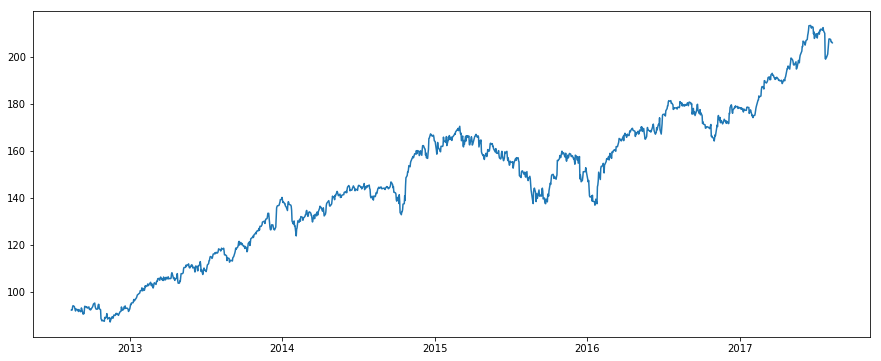

In [24]:
plt.plot(ts.index.to_pydatetime(), ts.values)

In [25]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolmean.index.to_pydatetime(), rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.index.to_pydatetime(), rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

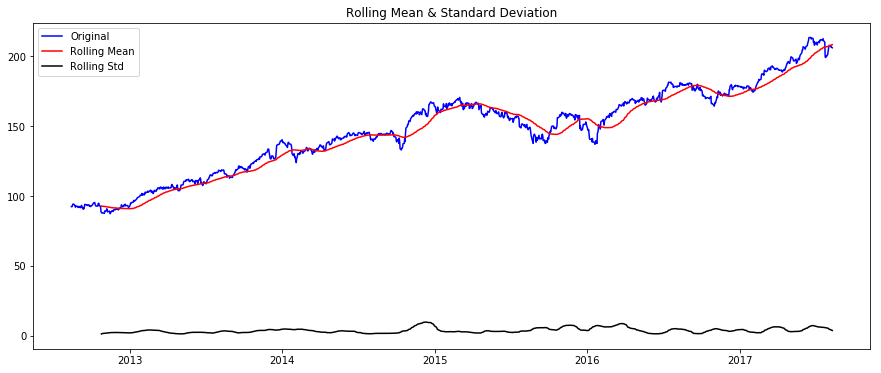

Results of Dickey-Fuller Test:
Test Statistic                   -0.598985
p-value                           0.871211
#Lags Used                        4.000000
Number of Observations Used    1253.000000
Critical Value (1%)              -3.435580
Critical Value (5%)              -2.863849
Critical Value (10%)             -2.568000
dtype: float64


In [26]:
test_stationarity(ts)

It is not stationary. since p-value > 0.05.

In [27]:
ts_week = ts.resample('W').mean()


In [29]:
ts_log = np.log(ts)


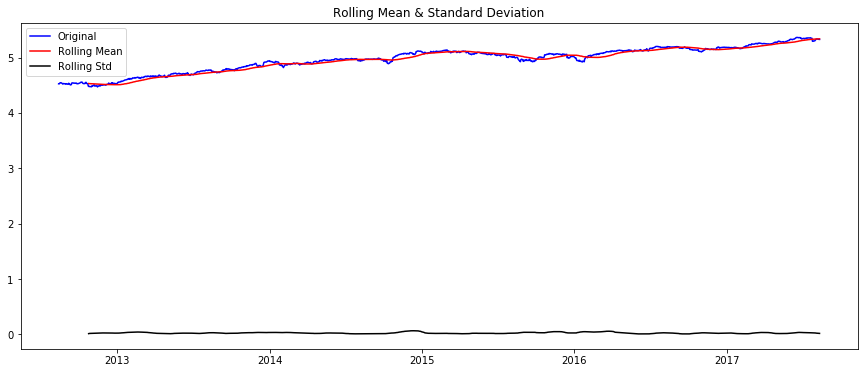

Results of Dickey-Fuller Test:
Test Statistic                   -1.225185
p-value                           0.662669
#Lags Used                        1.000000
Number of Observations Used    1256.000000
Critical Value (1%)              -3.435567
Critical Value (5%)              -2.863844
Critical Value (10%)             -2.567997
dtype: float64


In [30]:
test_stationarity(ts_log)

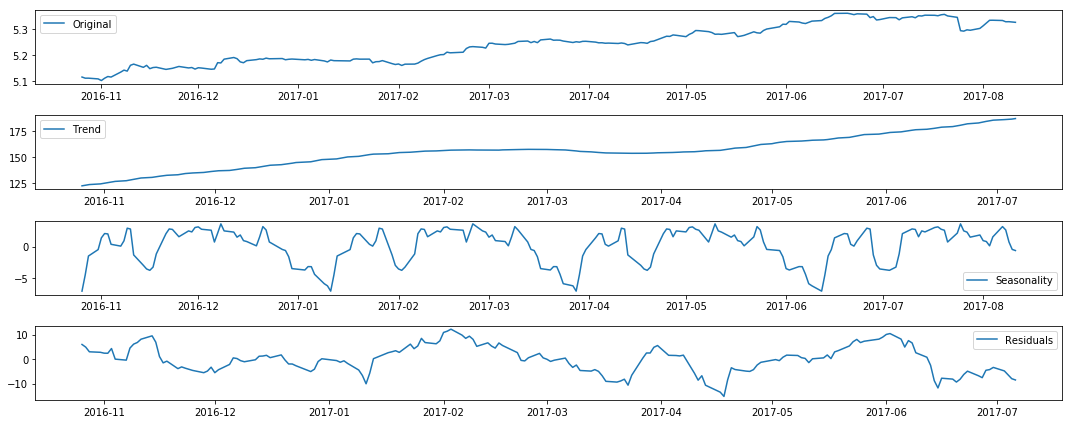

In [31]:

decomposition = seasonal_decompose(ts_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

ts_week_log_select = ts_log[-200:]

plt.subplot(411)
plt.plot(ts_week_log_select.index.to_pydatetime(), ts_week_log_select.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_week_log_select.index.to_pydatetime(), trend[-200:].values, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_week_log_select.index.to_pydatetime(), seasonal[-200:].values,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_week_log_select.index.to_pydatetime(), residual[-200:].values, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

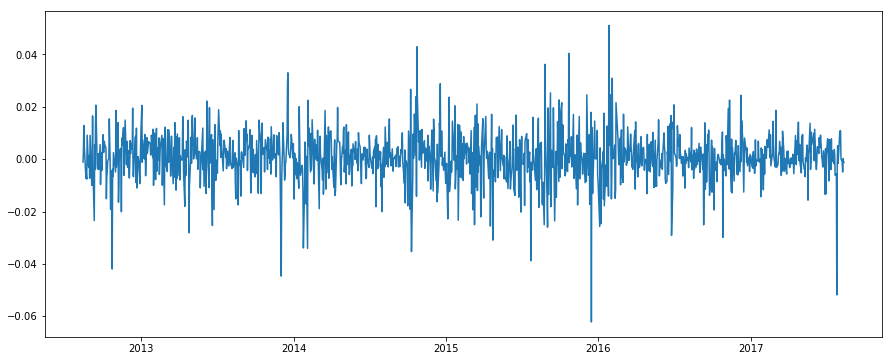

In [32]:
ts_week_log_diff = ts_log - ts_log.shift()
plt.plot(ts_week_log_diff.index.to_pydatetime(), ts_week_log_diff.values)

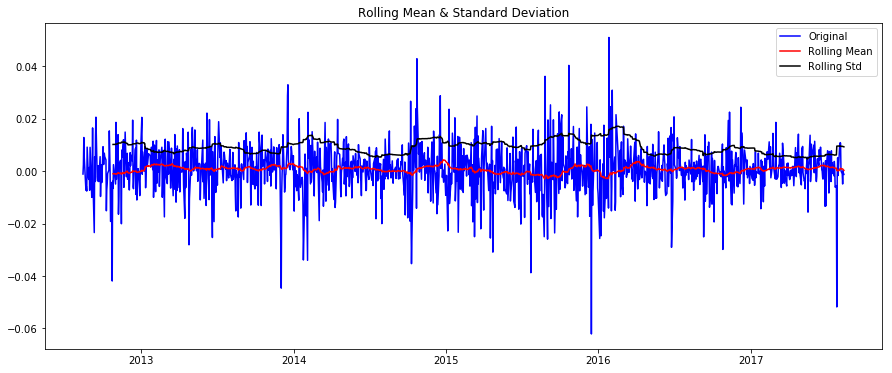

Results of Dickey-Fuller Test:
Test Statistic                  -36.993829
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1256.000000
Critical Value (1%)              -3.435567
Critical Value (5%)              -2.863844
Critical Value (10%)             -2.567997
dtype: float64


In [33]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

Preprocessing is done. Now we can try to fit the ARIMA model.

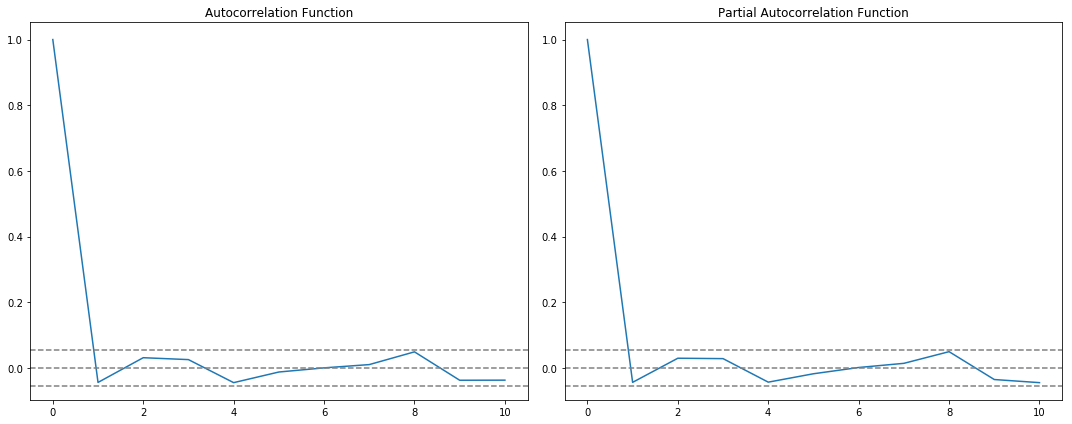

In [34]:
#ACF and PACF plots

lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [35]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)

C:\Users\DE117\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


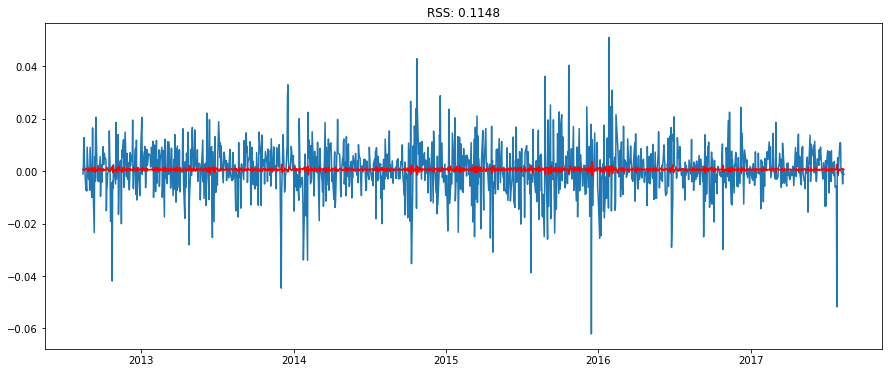

In [36]:
model = ARIMA(ts_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff.index.to_pydatetime(), ts_week_log_diff.values)
plt.plot(ts_week_log_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1257
Model:                 ARIMA(2, 1, 1)   Log Likelihood                4062.360
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sun, 17 Dec 2017   AIC                          -8114.721
Time:                        21:27:36   BIC                          -8089.038
Sample:                    08-14-2012   HQIC                         -8105.068
                         - 08-11-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      2.370      0.018       0.000       0.001
ar.L1.D.Close     0.1747      0.416      0.420      0.674      -0.640       0.990
ar.L2.D.Close     0.0416      0.032     

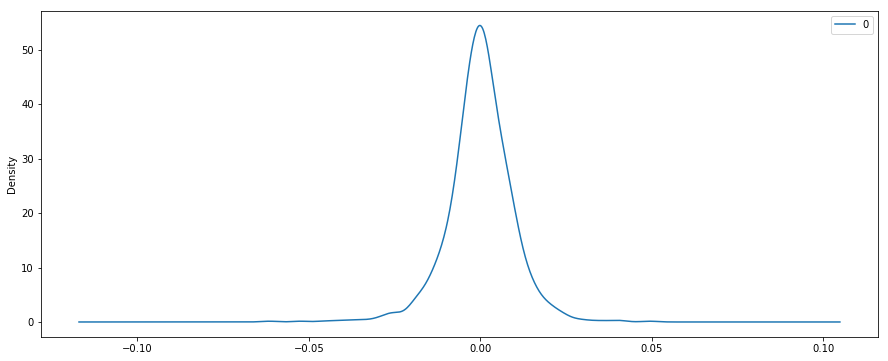

In [37]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [38]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
2012-08-14    0.000638
2012-08-15    0.000713
2012-08-16    0.000500
2012-08-17    0.000169
2012-08-20    0.000846
dtype: float64


In [39]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

In [40]:
#predictions_ARIMA = np.exp(predictions_ARIMA_log)
#plt.plot(ts_week.index.to_pydatetime(), ts_week.values)
#plt.plot(ts_week.index.to_pydatetime(), predictions_ARIMA.values)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

In [44]:
size = int(len(ts_log) - 30)
print('Size is ', size)
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

predictions_series = pd.Series(predictions, index = test.index)

Size is  1228
Printing Predicted vs Expected Values...


predicted=208.129309, expected=208.190000
predicted=208.224566, expected=209.830000
predicted=209.880775, expected=209.760000
predicted=209.953780, expected=208.020000
predicted=208.253170, expected=209.590000
predicted=209.600995, expected=210.490000
predicted=210.622922, expected=209.660000
predicted=209.877614, expected=211.300000
predicted=211.344345, expected=211.090000
predicted=211.289095, expected=211.770000
predicted=211.884346, expected=211.680000
predicted=211.849744, expected=211.310000
predicted=211.473695, expected=212.100000
predicted=212.193244, expected=212.450000
predicted=212.597976, expected=211.160000
predicted=211.382371, expected=210.000000
predicted=210.162845, expected=199.390000
predicted=199.951812, expected=199.030000
predicted=198.809879, expected=200.050000
predicted=200.039693, expected=199.720000
predicted=199.868385, expected=201.170000
predicted=201.222944, expected=203.180000
predicted=203.26302

Based on the 30 sample prediction above, we can see that most predicted values are close to the real values. But there are some predicted values have big difference with true values. So I deduct that there are some problem with the company or news that impair the revenue of the company.

In [ ]:
sc = SC()
feature = ['Open','High','Low','Volume']
X_train = mmm[feature]
y_train = mmm['Close']
clf = SVR(C = 0.01,epsilon = 0.1)
clf.fit(X_train_std,y_train)

In [ ]:
# engineer feature
# Dataset mmm


